Topic 2 - Topic Classification on News Article:
---

### As text classification:

First, let's introduce what Logistic Regression is. 

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) is a classification model that is very easy to implement and performs very well on linearly separable classes. It is one of the most widely used
algorithms for classification in industry too, which makes it attractive to play with.

_Very_ simplistically explained, Logistic Regression works as follows:

![Logistic Regression](https://github.com/guillermo-carrasco/logistic-sentiment/blob/master/images/logistic_regression.png?raw=true)

First we will define the input for our algorithm. The imput will be each sample in whatever dataset we are working with. Each sample will consist of several features. For example, if we're working with housing price prediction, the features for each sample could be the size of the house, number of rooms, etc. We'll call the input vector **X**.

For the algorythm to learn, we need to define variables that we can adjust accordingly to what we want to predict. We will create a vector of _weights_ (**W**) that the model will adjust in order to predict more accurately. The process of adjusting those weights is what we call **learning**.

For every input sample, we will perform a dot product of the features by the weights **XW**. This product is sometimes referred as _net input_. This will give us a real number. Since in this particular problem we want to _classify_ (positive/negative), we need squash this number in the range [0, 1]. This will give us the _probability_ of a positive event. A function that does precisely that is called **sigmoid**. The sigmoid function looks like this:

![sigmoid](https://raw.githubusercontent.com/guillermo-carrasco/logistic-sentiment/master/images/sigmoid.svg)

What sigmoid is doing is basically transforming big inputs into a value close to 1, and small inputs into a value close to 0. This is exactly what we want. 

We will do this for every sample in our training set and compute the errors. To calculate the error we only need to compare our prediction with the true label for each sample. We will sum the square errors of all the samples to get a global prediction error. This will be our **cost function**.

A cost function is then something we want to minimize. **Gradient descent** is a method for finding the minimum of a function of multiple variables, such like the one we're dealing with here.

### The training process

In order for logistic regression to learn, we need to repeat the process descrived before several times. Each one of these times is called an **epoch**. The number of epochs to run depends on the problem and the training data. It is... yes, another tunnable parameter of the algorithm.

The set of all tunnable parameters is called **hyperparameters** of the model.

Like with the leatning rate, we need to be careful when choosing the number of epochs: If we train too many epochs, we risk **overfitting**. This means that our model will "memorize" the training data and will generalize badly when presented new data. 

If we train too little, it will fail to find any pattern and the prediction accuracy will be very low. This is known as **underfitting**.

There are techniques that help prevent overfitting. These **regularization** techniques are out of the scope of this tutorial, but... guess! It's also something to tune and experiment with :)

This is why when training a model you need to set aside a _test dataset_ in order to know the accuracy of your algorithm in unknown data. The test dataset will **never** be used during training

In [ ]:
!ls news-topic-classification

'BBC News Sample Solution.csv'	'BBC News Train.csv'
'BBC News Test.csv'		 README.md


In [ ]:
import pandas as pd

train = pd.read_csv('news-topic-classification/BBC News Train.csv')
test = pd.read_csv('news-topic-classification/BBC News Test.csv')
train.shape, test.shape

((1490, 3), (735, 2))

In [ ]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


As we can see, we have 3 features each corresponding to specific field on reddit post: the **FLAIR** to be predicted, the **TITLE** of the post and the **BODY** of the post.  The structure of text features varies a lot between each  observation. They have different lengths, letters, numbers, extrange characters, etc. 

This makes it hard to build a classifier. If they were all correct dictionary words, we could use a **lexicon** to punctuate words. However because of the nature of social media language, we cannot do that. 

So we need a way of scoring the words such that words that appear in a reddit post can have equal score in each individual post.

But first... how do we represent the text features as vectors we can input to our algorithm?

### Bag of words

One thing we could do to represent the text featues as equal-sized vectors of numbers is the following:

* Create a list (vocabulary) with all the unique words in the whole corpus of twits. 
* We construct a feature vector from each post that contains the counts of how often each word occurs in the particular post.

_Note that since the unique words in each post represent only a small subset of all the words in the bag-of-words vocabulary, the feature vectors will mostly consist of zeros_

Let's construct the bag of words. We will work with a smaller example for illustrative purposes, and at the end we will work with our real data.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

twits = [
    'Google maps caught a plane landing at Madurai airport- Tamil Nadu',
    'Palette at Pollution',
    'Chaliye  2019 ko Vannakam. ( Welcome to 2019)',
    'I am not sure about how this is going to end...'
]

count = CountVectorizer()
bag = count.fit_transform(twits)

count.vocabulary_

{'2019': 0,
 'about': 1,
 'airport': 2,
 'am': 3,
 'at': 4,
 'caught': 5,
 'chaliye': 6,
 'end': 7,
 'going': 8,
 'google': 9,
 'how': 10,
 'is': 11,
 'ko': 12,
 'landing': 13,
 'madurai': 14,
 'maps': 15,
 'nadu': 16,
 'not': 17,
 'palette': 18,
 'plane': 19,
 'pollution': 20,
 'sure': 21,
 'tamil': 22,
 'this': 23,
 'to': 24,
 'vannakam': 25,
 'welcome': 26}

### How relevant are words? Term frequency-inverse document frequency

We could use these raw term frequencies to score the words in our algorithm. There is a problem though: If a word is very frequent in _all_ documents, then it probably doesn't carry a lot of information. In order to tacke this problem we can use **term frequency-inverse document frequency**, which will reduce the score the more frequent the word is accross all twits. It is calculated like this:

\begin{equation*}
tf-idf(t,d) = tf(t,d) ~ idf(t,d)
\end{equation*}

_tf(t,d)_ is the raw term frequency descrived above. _idf(t,d)_ is the inverse document frequency, than can be calculated as follows:

\begin{equation*}
\log \frac{n_d}{1+df\left(d,t\right)}
\end{equation*}

where `n` is the total number of documents and _df(t,d)_ is the number of documents where the term `t` appears. 

The `1` addition in the denominator is just to avoid zero term for terms that appear in all documents. Ans the `log` ensures that low frequency term don't get too much weight.

Fortunately for us `scikit-learn` does all those calculations for us:

In [ ]:
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

np.set_printoptions(precision=2)

# Feed the tf-idf transformer with our previously created Bag of Words
tfidf.fit_transform(bag).toarray()

array([[0.  , 0.  , 0.32, 0.  , 0.25, 0.32, 0.  , 0.  , 0.  , 0.32, 0.  ,
        0.  , 0.  , 0.32, 0.32, 0.32, 0.32, 0.  , 0.  , 0.32, 0.  , 0.  ,
        0.32, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.49, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.62, 0.  , 0.62, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.68, 0.  , 0.  , 0.  , 0.  , 0.  , 0.34, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.27, 0.34, 0.34],
       [0.  , 0.32, 0.  , 0.32, 0.  , 0.  , 0.  , 0.32, 0.32, 0.  , 0.32,
        0.32, 0.  , 0.  , 0.  , 0.  , 0.  , 0.32, 0.  , 0.  , 0.  , 0.32,
        0.  , 0.32, 0.25, 0.  , 0.  ]])

### Data clean up

Basic data cleanup includes:

* lowercase
* stopwords removal

since, most library does lowercase of character by default we can focus on stopwords removal


### Removing stop words

Now that we know how to format and score our input, we can start doing the analysis! Can we?... Well, we _can_, but let's look at our **real** vocabulary. Specifically, the most common words:

In [ ]:
from collections import Counter

vocab = Counter()
for article in train.Text:
    for word in article.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('', 43255),
 ('the', 34992),
 ('to', 16568),
 ('of', 12970),
 ('and', 12366),
 ('a', 12102),
 ('in', 11696),
 ('s', 5899),
 ('for', 5773),
 ('is', 5478),
 ('that', 5207),
 ('it', 5000),
 ('on', 4991),
 ('was', 4019),
 ('he', 3866),
 ('be', 3803),
 ('with', 3482),
 ('said', 3401),
 ('has', 3250),
 ('as', 3245)]

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

vocab_reduced = Counter()
for w, c in vocab.items():
    if not w in stop:
        vocab_reduced[w]=c

vocab_reduced.most_common(20)

[('', 43255),
 ('said', 3401),
 ('-', 2125),
 ('mr', 1969),
 ('would', 1710),
 ('also', 1424),
 ('new', 1329),
 ('people', 1277),
 ('us', 1138),
 ('one', 1125),
 ('could', 1031),
 ('said.', 987),
 ('year', 933),
 ('first', 889),
 ('last', 883),
 ('two', 801),
 ('.', 790),
 ('world', 712),
 ('government', 703),
 ('uk', 695)]

### Removing special characters and "trash"

We still see a very uneaven distribution. If you look closer, you'll see that we're also taking into consideration punctuation signs ('-', '|', etc) and other html tags like `&amp`. We can definitely remove them for the Text classification task, but we will try to keep the emoticons, since those _do_ have a sentiment load:

In [ ]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

print(preprocessor('This!! India’s satya isn’t sundar :) is <b>nice</b>'))

this india s satya isn t sundar is nice :)


In [ ]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

print(tokenizer('Hi there, I am loving this, like with a lot of love'))
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love'))

['Hi', 'there,', 'I', 'am', 'loving', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']
['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']


### Training Logistic Regression

We are finally ready to train our algorythm. We need to choose the best hyperparameters like the _learning rate_ or _regularization strength_. We also would like to know if our algorithm performs better steaming words or not, or removing html or not, etc...

To take these decisions methodically, we can use a Grid Search. Grid search is a method of training an algorythm with different variations of parameters to latter select the best combination

In [ ]:
from sklearn.model_selection import train_test_split

# split the dataset in train and test
X = train['Text']
y = train['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

### Hyperparameter Optimization:

It is based on the asssumption that: **Every thing is a hyperparameter from scaling to number of layers in a neural network, from which preprocessor to use to whether to remove stopwords or not**

So, we have used Grid Search to create a set of axis consisting of:
* whether to include stpowords removal in our pipeline or not
* which tokenizer to use
* which to regularizer to use
* and search through a set of values of C

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [ ]:
# Note: This may take a long while to execute, like... 1 or 2 hours
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 28.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__preprocessor': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7f3c984527b8>}
Best accuracy: 0.975


In [ ]:
clf = gs_lr_tfidf.best_estimator_
print('Accuracy in test: %.3f' % clf.score(X_test, y_test))

Accuracy in test: 0.960


### Evaluating our classifier on test set:

In [ ]:
import pandas as pd

test_true = pd.read_csv('/content/news-topic-classification/BBC News Sample Solution.csv')
y_true = test_true.Category.tolist()

In [ ]:
test = pd.read_csv('/content/news-topic-classification/BBC News Test.csv')
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [ ]:
X_test = test.Text.tolist()
preds = clf.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [ ]:
class2idxs = {}
name_class = train.Category.unique()
for i, name in enumerate(name_class):
    class2idxs[name] = i

idxs2class = {i:k for k, i in class2idxs.items()}

In [ ]:
Y_true = []
for classes in y_true:
  Y_true.append(class2idxs[classes])

Y_Pred = []
for classes in preds:
  Y_Pred.append(class2idxs[classes])

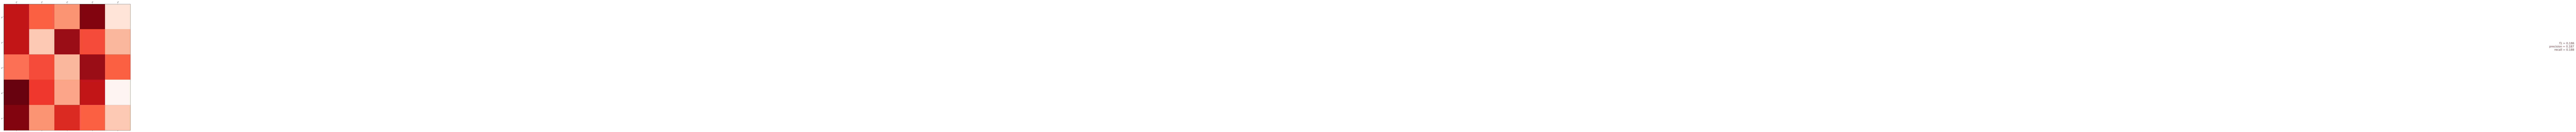

f1 score: 0.186, precision: 0.187, recall: 0.188


<Figure size 1080x1080 with 0 Axes>

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

CLASSES = np.zeros(train.Category.nunique(),)
cmat = confusion_matrix(Y_true, Y_Pred, labels=range(len(CLASSES)))
score = f1_score(Y_true, Y_Pred, labels=range(len(CLASSES)), average='macro')
precision = precision_score(Y_true, Y_Pred, labels=range(len(CLASSES)), average='macro')
recall = recall_score(Y_true, Y_Pred, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))